In [1]:
import pickle

import torch
from torchvision.transforms import v2 as transforms

import numpy as np
from ultralytics import YOLO

from keyrover import *
from keyrover.datasets import *
from keyrover.vision import *
from keyrover.color import image_color
from keyrover.ml import get_device, TexCoordsRegressionModel

2024-11-09 23:56:05.921 Python[48548:8719859] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [2]:
device = get_device()

In [3]:
SIZE = (256, 256)

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*get_dataset_norm_params(version=3))
])

In [391]:
with open(f"{RAW_TEXCOORDS}/key_texcoords_mean.bin", "rb") as file:
    U_means = pickle.load(file)
    V_means = pickle.load(file)

palette = []
palette_to_cls = {}

for (cls, u), (_, v) in zip(U_means.items(), V_means.items()):
    palette.append([u, v])
    palette_to_cls[(u, v)] = cls

palette = np.array(palette)

In [5]:
ARCH = "unet"
BACKBONE = "timm-regnetx_004"
name = "brisk-plant-1"

model = TexCoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, lr=0.0, activation="tanh")
model.load_state_dict(torch.load(f"models/texcoords/{name}-{ARCH}-{BACKBONE}.pt", weights_only=True))
model.to(device)
model.eval()

yolo = YOLO("models/yolo/train4/weights/best.pt")


0: 320x320 71 keys, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)


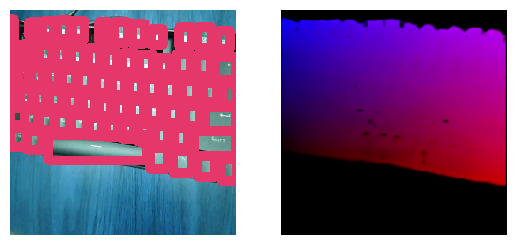

In [539]:
# vidcap = cv2.VideoCapture(f"{TEST_DATASET}/90.mp4")
# total = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
# frame = random.randint(0, total)
# print(frame)
# vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame)
# _, img = vidcap.read()

img = cv2.imread(f"{TEST_DATASET}/1.jpg")

img = cv2.resize(img, SIZE)
pred = yolo.predict(img, conf=0.35, iou=0.3)[0]
keyboard_mask = model.predict(transform(img))
keyboard_mask = reorder_image_axes(keyboard_mask)

out = plot_yolo(pred, scale=1, draw_text=False, plot=False)
imshow(out, keyboard_mask)

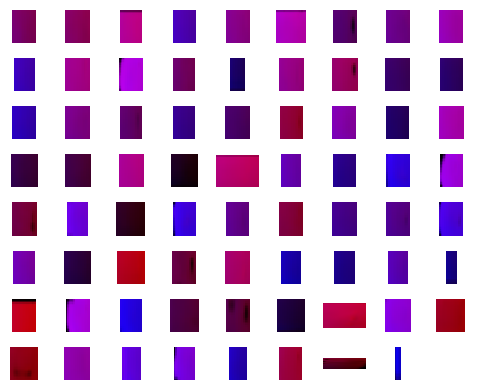

In [540]:
img = pred.orig_img

keys = [crop_rect(keyboard_mask, box) for box in pred.boxes]
colors = np.array([color * 256 for key in keys if (color := image_color(key)) is not None])
show_images(keys, figsize=(5, 4))

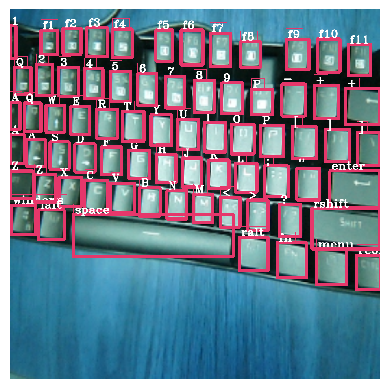

In [541]:
# Unfiltered classification algorithm

classes = [palette_to_cls[tuple(color)] for color in to_palette(colors, palette)]
labels = [id_to_key.get(cls) for cls in classes]

plot_predictions(pred.orig_img, pred.boxes, labels, font_size=0.25, line_width=0, scale=5)

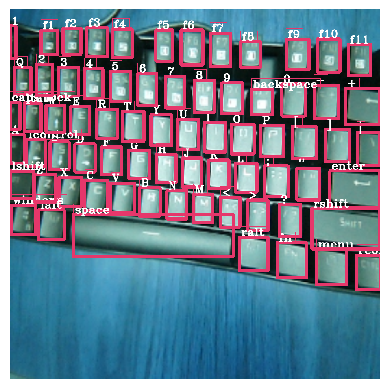

In [542]:
# Greedy classification algorithm

n = colors.shape[0]
m = palette.shape[0]

color_matrix = np.repeat(colors[:, np.newaxis], m, axis=1)
dist = np.linalg.norm(color_matrix - palette, axis=-1)
labels = [None] * n

for _ in range(n):
    index = np.unravel_index(dist.argmin(), dist.shape)
    closest_color = palette[index[1]]
    closest_key = palette_to_cls[tuple(closest_color)]

    labels[index[0]] = id_to_key.get(closest_key)
    dist[index[0]] = float("inf")
    dist[:, index[1]] = float("inf")

plot_predictions(pred.orig_img, pred.boxes, labels, font_size=0.25, line_width=0, scale=5)

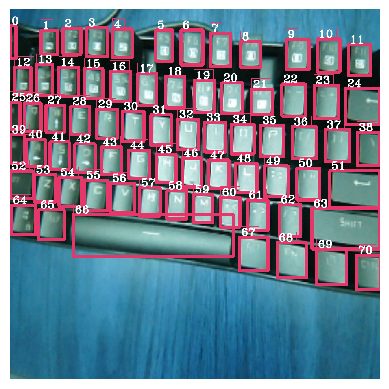

In [543]:
class Box:
    def __init__(self, box, n: int, color):            
        try:
            self.x, self.y, self.w, self.h = map(float, box.xywh[0])
        except AttributeError:
            self.x, self.y = box
            self.w = 0
            self.h = 0
            
        self.n = n

        self.box = box
        self.color = color

    def __sub__(self, other):
        # return (self.color - other.color)[:2]
        return np.array([self.x - other.x, self.y - other.y])

    def __repr__(self):
        return f"Box({self.x:.2f}, {self.y:.2f}, n={self.n})"

    def norm(self) -> float:
        return (self.x ** 2 + self.y ** 2) ** 0.5

    def topleft(self):
        return np.array([self.x - self.w / 2, self.y - self.h / 2])

    def topright(self):
        return np.array([self.x + self.w / 2, self.y - self.h / 2])

    def bottomleft(self):
        return np.array([self.x - self.w / 2, self.y + self.h / 2])

    def bottomright(self):
        return np.array([self.x + self.w / 2, self.y + self.h / 2])

    @property
    def xyxy(self) -> np.ndarray:
        return np.array([[self.x - self.w / 2, self.y - self.h / 2, self.x + self.w / 2, self.y + self.h / 2]])

    area = property(lambda self: self.w * self.h)


def sort_boxes(boxes):
    sorted_boxes = []
    rows = []

    while len(boxes):
        a = sorted(boxes, key=lambda p: p.x + 2 * p.y)[0]  # top-left box
        b = sorted(boxes, key=lambda p: p.x - 2 * p.y)[-1]  # top-right box

        if a == b:
            boxes.remove(a)
            continue

        # u1 = b.topright() - a.topleft()
        # u1 /= np.linalg.norm(u1)
        # 
        # u2 = b.bottomright() - a.bottomleft()
        # u2 /= np.linalg.norm(u2)

        u3 = b - a  # normalized direction vector
        u3 /= np.linalg.norm(u3)

        row = []
        remaining = []

        for box in boxes:
            # d1 = abs(np.cross(box - a.topleft(), u1))  # distance between box and lines
            # d2 = abs(np.cross(box - a.bottomleft(), u2))  # distance between box and lines
            d3 = abs(np.cross(box - a, u3))

            (row if (d3 < 15) else remaining).append(box)  # todo better threshold

        if len(row) <= 2:
            boxes.remove(a)
            boxes.remove(b)
            continue

        row = sorted(row, key=lambda h: h.x)
        rows.append(row)
        sorted_boxes.extend(row)
        boxes = remaining

    return sorted_boxes, rows


boxes, rows = sort_boxes([Box(box, i, color) for i, (box, color) in enumerate(zip(pred.boxes, colors))])
plot_predictions(pred.orig_img, boxes, range(len(boxes)), font_size=0.25, line_width=0, scale=5)

In [544]:
_, sorted_palette = sort_boxes([Box((color[0], -color[1]), i, color) for i, color in enumerate(palette)])

sorted_palette_indices = [[palette_to_cls[tuple(box.color[:2])] for box in row] for row in sorted_palette]
sorted_palette = [[box.color for box in row] for row in sorted_palette]

In [551]:
n_hat = len(boxes)

offsets = [0, 1, 0, 0, 0, 1]
layout = []
palette_indices = []
for i, row in enumerate(rows):
    offset = offsets[i]
    layout.extend(sorted_palette[i][offset:len(row) + offset])
    palette_indices.append(sorted_palette_indices[i][offset:len(row) + offset])

layout = np.array(layout)

min_ = layout.min(axis=0)
max_ = layout.max(axis=0)
layout = (layout - min_) / (max_ - min_) - 0.5

L = layout.flatten(order="F")
palette_indices

[[38, 47, 48, 49, 50, 43, 44, 45, 46, 39, 40, 41],
 [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 27],
 [37, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 87],
 [85, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 96],
 [36, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 28],
 [34, 33, 13, 32, 31, 30, 29]]

In [552]:
C = np.array([box.color for box in boxes])
C = C - C.min(axis=0)
C /= C.max(axis=0)
C -= 0.5

Z = np.zeros(C.shape)
P = np.asarray(np.bmat([[C, Z], [Z, C]]))
P

array([[       -0.5,      0.4054,           0,           0],
       [   -0.38501,     0.49834,           0,           0],
       [    -0.3082,     0.48436,           0,           0],
       [   -0.23853,     0.46678,           0,           0],
       [   -0.16618,     0.47428,           0,           0],
       [  -0.060128,     0.47431,           0,           0],
       [   0.012998,      0.4755,           0,           0],
       [   0.080912,     0.45612,           0,           0],
       [    0.17756,     0.46371,           0,           0],
       [    0.28075,     0.47152,           0,           0],
       [    0.33157,       0.482,           0,           0],
       [    0.38491,         0.5,           0,           0],
       [   -0.43953,     0.22022,           0,           0],
       [    -0.3806,     0.25037,           0,           0],
       [   -0.30523,     0.27184,           0,           0],
       [   -0.23454,     0.27163,           0,           0],
       [   -0.16167,    

In [553]:
A = np.linalg.inv(P.T @ P) @ P.T @ L
A = A.reshape((2, 2))
A

array([[     1.0175,   0.0080586],
       [  -0.018151,       1.069]])

In [554]:
C_hat = (A @ C.T).T
C_hat

array([[   -0.50548,     0.44246],
       [   -0.38773,     0.53973],
       [   -0.30969,     0.52339],
       [   -0.23894,     0.50333],
       [   -0.16526,     0.51003],
       [  -0.057358,     0.50814],
       [   0.017057,     0.50808],
       [   0.086003,     0.48614],
       [    0.18441,     0.49249],
       [    0.28946,     0.49897],
       [    0.34126,     0.50925],
       [    0.39568,     0.52752],
       [   -0.44545,      0.2434],
       [   -0.38524,     0.27456],
       [   -0.30838,     0.29614],
       [   -0.23645,     0.29463],
       [   -0.16233,     0.29095],
       [  -0.090349,     0.27337],
       [  -0.022097,     0.26347],
       [   0.062735,     0.25094],
       [    0.14169,     0.24372],
       [    0.20991,     0.23547],
       [    0.27889,     0.25393],
       [    0.33707,     0.27634],
       [     0.3979,     0.29541],
       [   -0.47299,    0.040804],
       [   -0.41917,    0.057641],
       [   -0.35681,    0.075127],
       [    -0.2764,

In [555]:
print("Before:", np.linalg.norm(layout.flatten() - C.flatten()))
print("After:", np.linalg.norm(layout.flatten() - C_hat.flatten()))

Before: 0.41559401131798707
After: 0.3715165136385499


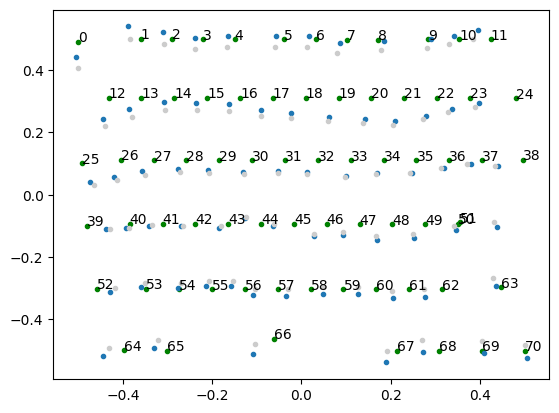

In [556]:
x, y = layout.T
plt.scatter(x, y, marker=".", c="green")

for i in range(len(x)):
    plt.annotate(i, (x[i], y[i]))

x, y = C_hat.T
plt.scatter(x, y, marker=".")

x, y = C.T
plt.scatter(x, y, marker=".", c="#ccc")

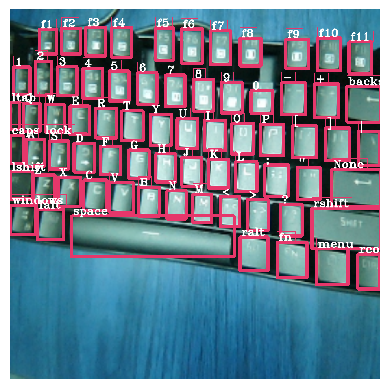

In [538]:
# Topological + Greedy classification algorithm

labels = [id_to_key.get(label) for row in palette_indices for label in row]
plot_predictions(pred.orig_img, boxes, labels, font_size=0.25, line_width=0, scale=5)